#  Les Imports

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Librairie re pour traiter des caratères spécifiques
import re
#Librairie de netoyage de tweets
!pip install tweet-preprocessor
import preprocessor as tpr
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, f1_score
from sklearn.svm import SVC

# Creation du DataFrame

In [2]:
# Importation du premier dataset
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data = list(parse_data('./Sarcasm_Headlines_Dataset.json'))

In [3]:
sarc = pd.DataFrame(data)

In [4]:
# Importation du deuxieme dataset
data = list(parse_data('./Sarcasm_Headlines_Dataset_v2.json'))

In [5]:
sarc_2 = pd.DataFrame(data)

# Comparaison et fusion des 2 datasets

In [6]:
sarc_2['is_sarcastic'].mean()

0.476396799329117

In [7]:
sarc['is_sarcastic'].mean()

0.43895316185555433

In [8]:
# Fusion des 2 datasets et suppression des doublons
sarc = pd.concat([sarc,sarc_2])
sarc = sarc.drop_duplicates()
sarc.reset_index(drop=True,inplace=True)

In [9]:
sarc.describe(include='all')

,article_link,headline,is_sarcastic
count,28617,28617,28617.000000
unique,28617,28503,NaN
top,https://www.huffingtonpost.com/entry/the-missi...,"'no way to prevent this,' says only nation whe...",NaN
freq,1,12,NaN
mean,NaN,NaN,0.476395
std,NaN,NaN,0.499451
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,1.000000


In [10]:
# Check des cases vides
sarc.isnull().any()

article_link    False
headline        False
is_sarcastic    False
dtype: bool

# Data Cleaning

In [11]:
# Utilisation de la librairie re pour traiter des caratères spécifiques
# Choix des caractères à effacer et à remplacer

replace_q = re.compile("(\?)")
replace_ex = re.compile("(\!)")
to_remove = re.compile("(\.)|(\;)|(\:)|(\')|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")

In [12]:
# Fonction de cleaning de la data utilisant tweet-processor et re

def cleaner(line):
    tmp_line = tpr.clean(line)
    tmp_line = replace_q.sub(" ? ",tmp_line.lower())
    tmp_line = replace_ex.sub(" ! ",tmp_line)
    tmp_line = to_remove.sub("",tmp_line)
    return tmp_line

In [13]:
# Cleaning de la data
h_clean = sarc['headline'].apply(cleaner)

# Ajout de la data clean au dataset
sarc["headline_clean"] = h_clean

In [14]:
sarc['headline_clean']

0        former versace store clerk sues over secret bl...
1        the roseanne revival catches up to our thorny ...
2        mom starting to fear sons web series closest t...
3        boehner just wants wife to listen not come up ...
4        jk rowling wishes snape happy birthday in the ...
                               ...                        
28612    tyson holds contest to let fans submit new ide...
28613    increasingly cocky bernie sanders announces he...
28614    cash-strapped zuckerberg forced to sell millio...
28615    grocery store bar actually has great little ha...
28616    study  of marathon spectators only attend for ...
Name: headline_clean, Length: 28617, dtype: object

In [15]:
sarc['headline'][28589]

'stock value of billions of otherwise worthless data, photos, videos, opinions plummets'

In [16]:
sarc['headline_clean'][28589]

'stock value of billions of otherwise worthless data photos videos opinions plummets'

In [17]:
sarc['is_sarcastic'].mean()

0.4763951497361708

# Construction des sets Train et Test

In [18]:
# Construction des features et de la target
x = sarc.headline_clean.values
y = sarc.is_sarcastic.values

x_train, x_test, y_train, y_test = train_test_split(x,
                                                   y,
                                                   test_size=0.3,
                                                   stratify=y)

# Vectorisation

In [19]:
#Vectorisation avec CountVectorizer
vectorizer = CountVectorizer(binary=True, stop_words="english")


x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

In [20]:
#Vectorisation avec TfidfVectorizer
t_vectorizer = TfidfVectorizer(use_idf=True, stop_words="english")

t_vectorized = t_vectorizer.fit(x)

x_train_tfidf = t_vectorizer.transform(x_train)
x_test_tfidf = t_vectorizer.transform(x_test)

# Construction des modèles

**Regression Logistique**

In [21]:
# Regression Logistique avec CountVectorizer

cv_reg = LogisticRegression()
cv_reg.fit(x_train_vec,y_train)

C:\Users\shexx\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [22]:
y_train_vec_pred = cv_reg.predict(x_train_vec)

In [23]:
y_test_vec_pred = cv_reg.predict(x_test_vec)

In [24]:
# score train
cv_reg.score(x_train_vec,y_train)


0.9528730467774948

In [25]:
# score train
cv_reg.score(x_test_vec,y_test)

0.7886093640810622

In [26]:
# Regression Logistique avec TfidfVectorizer

tv_reg = LogisticRegression()
tv_reg.fit(x_train_tfidf,y_train)

LogisticRegression()

In [27]:
# score train
tv_reg.score(x_train_tfidf,y_train)

0.9055963256951725

In [28]:
# score test
tv_reg.score(x_test_tfidf,y_test)

0.779874213836478

    Matrices de confusion

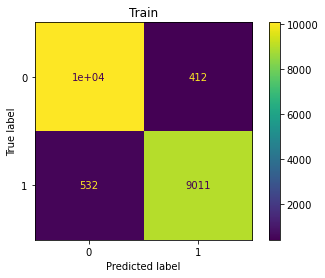

accuracy-score on train set :  0.9528730467774948
precision-score on train set :  0.9562771940995437
recall-score on train set :  0.9442523315519229
F1-score on train set :  0.9502267215016346


In [29]:
#Matrice et score pour train avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_reg, x_train_vec,y_train)
cm_vec.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", cv_reg.score(x_train_vec, y_train))
print("precision-score on train set : ", precision_score(y_train,cv_reg.predict(x_train_vec)))
print("recall-score on train set : ", recall_score(y_train,cv_reg.predict(x_train_vec)))
print("F1-score on train set : ", f1_score(y_train,cv_reg.predict(x_train_vec)))

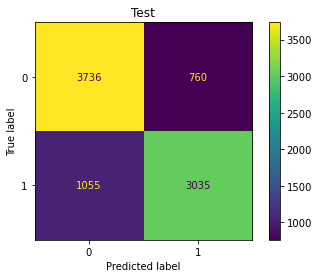

accuracy-score on test set :  0.7886093640810622
precision-score on test set :  0.7997364953886693
recall-score on test set :  0.7420537897310513
F1-score on test set :  0.7698161065313888


In [30]:
#Matrice et score pour test avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_reg, x_test_vec,y_test)
cm_vec.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", cv_reg.score(x_test_vec, y_test))
print("precision-score on test set : ", precision_score(y_test,cv_reg.predict(x_test_vec)))
print("recall-score on test set : ", recall_score(y_test,cv_reg.predict(x_test_vec)))
print("F1-score on test set : ", f1_score(y_test,cv_reg.predict(x_test_vec)))

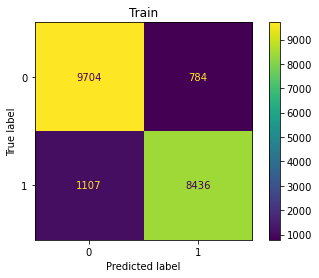

accuracy-score on train set :  0.9055963256951725
precision-score on train set :  0.9149674620390456
recall-score on train set :  0.8839987425337944
F1-score on train set :  0.899216543196717


In [31]:
#Matrice et score pour train avec TfidfVectorizer
cm_tfidf = plot_confusion_matrix(tv_reg, x_train_tfidf,y_train)
cm_tfidf.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", tv_reg.score(x_train_tfidf, y_train))
print("precision-score on train set : ", precision_score(y_train,tv_reg.predict(x_train_tfidf)))
print("recall-score on train set : ", recall_score(y_train,tv_reg.predict(x_train_tfidf)))
print("F1-score on train set : ", f1_score(y_train,tv_reg.predict(x_train_tfidf)))

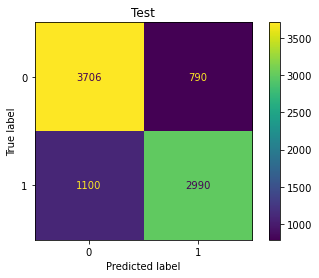

accuracy-score on test set :  0.779874213836478
precision-score on test set :  0.791005291005291
recall-score on test set :  0.7310513447432763
F1-score on test set :  0.7598475222363406


In [32]:
#Matrice et score pour test avec TfidfVectorizer
cm_tfidf = plot_confusion_matrix(tv_reg, x_test_tfidf,y_test)
cm_tfidf.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", tv_reg.score(x_test_tfidf, y_test))
print("precision-score on test set : ", precision_score(y_test,tv_reg.predict(x_test_tfidf)))
print("recall-score on test set : ", recall_score(y_test,tv_reg.predict(x_test_tfidf)))
print("F1-score on test set : ", f1_score(y_test,tv_reg.predict(x_test_tfidf)))

**Random Forest**

In [33]:
# Randomforest avec CountVectorizer

cv_rf = RandomForestClassifier(n_estimators=75, max_depth=20)
cv_rf.fit(x_train_vec,y_train)

RandomForestClassifier(max_depth=20, n_estimators=75)

In [34]:
# score train
cv_rf.score(x_train_vec,y_train)

0.7015126553841545

In [35]:
# score test
cv_rf.score(x_test_vec,y_test)

0.663754949918472

In [36]:
# Randomforest avec TfidfVectorizer

tv_rf = RandomForestClassifier(n_estimators=75, max_depth=20)
tv_rf.fit(x_train_tfidf,y_train)

RandomForestClassifier(max_depth=20, n_estimators=75)

In [37]:
# score train
tv_rf.score(x_train_tfidf,y_train)

0.7072537566771504

In [38]:
# score test
tv_rf.score(x_test_tfidf,y_test)

0.6650361052876776

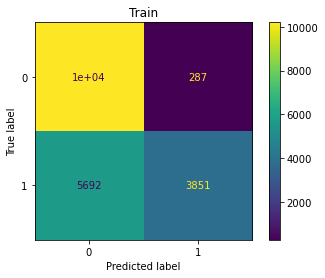

accuracy-score on train set :  0.7015126553841545
precision-score on train set :  0.9306428226196231
recall-score on train set :  0.4035418631457613
F1-score on train set :  0.5629705430889556


In [39]:
#Matrice et score pour train avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_rf, x_train_vec,y_train)
cm_vec.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", cv_rf.score(x_train_vec, y_train))
print("precision-score on train set : ", precision_score(y_train,cv_rf.predict(x_train_vec)))
print("recall-score on train set : ", recall_score(y_train,cv_rf.predict(x_train_vec)))
print("F1-score on train set : ", f1_score(y_train,cv_rf.predict(x_train_vec)))

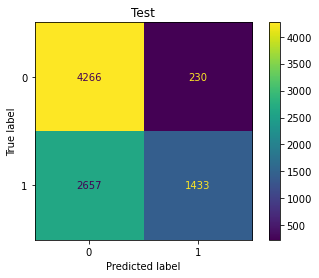

accuracy-score on test set :  0.663754949918472
precision-score on test set :  0.8616957306073362
recall-score on test set :  0.3503667481662592
F1-score on test set :  0.49817486528767596


In [40]:
#Matrice et score pour test avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_rf, x_test_vec,y_test)
cm_vec.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", cv_rf.score(x_test_vec, y_test))
print("precision-score on test set : ", precision_score(y_test,cv_rf.predict(x_test_vec)))
print("recall-score on test set : ", recall_score(y_test,cv_rf.predict(x_test_vec)))
print("F1-score on test set : ", f1_score(y_test,cv_rf.predict(x_test_vec)))

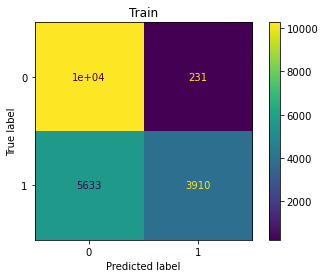

accuracy-score on train set :  0.7072537566771504
precision-score on train set :  0.9442163728567978
recall-score on train set :  0.4097244053232736
F1-score on train set :  0.571470330312774


In [41]:
#Matrice et score pour train avec TfidfVectorizer
cm_tfidf = plot_confusion_matrix(tv_rf, x_train_tfidf,y_train)
cm_tfidf.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", tv_rf.score(x_train_tfidf, y_train))
print("precision-score on train set : ", precision_score(y_train,tv_rf.predict(x_train_tfidf)))
print("recall-score on train set : ", recall_score(y_train,tv_rf.predict(x_train_tfidf)))
print("F1-score on train set : ", f1_score(y_train,tv_rf.predict(x_train_tfidf)))

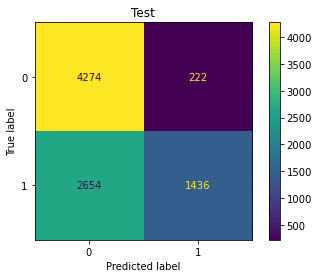

accuracy-score on test set :  0.6650361052876776
precision-score on test set :  0.8661037394451147
recall-score on test set :  0.3511002444987775
F1-score on test set :  0.49965205288796105


In [42]:
#Matrice et score pour test avec TfidfVectorizer
cm_tfidf = plot_confusion_matrix(tv_rf, x_test_tfidf,y_test)
cm_tfidf.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", tv_rf.score(x_test_tfidf, y_test))
print("precision-score on test set : ", precision_score(y_test,tv_rf.predict(x_test_tfidf)))
print("recall-score on test set : ", recall_score(y_test,tv_rf.predict(x_test_tfidf)))
print("F1-score on test set : ", f1_score(y_test,tv_rf.predict(x_test_tfidf)))

**Support Vector Machine**

In [43]:
# SVM avec CountVectorizer

cv_svm = SVC()
cv_svm.fit(x_train_vec,y_train)

SVC()

In [44]:
# score train
cv_svm.score(x_train_vec,y_train)

0.9725425590334981

In [45]:
# score test
cv_svm.score(x_test_vec,y_test)

0.7856976473328675

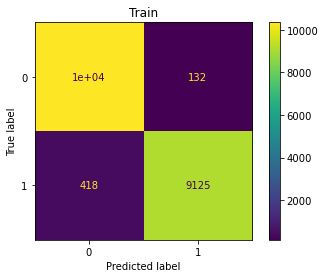

accuracy-score on train set :  0.9725425590334981
precision-score on train set :  0.9857405206870476
recall-score on train set :  0.9561982605050823
F1-score on train set :  0.9707446808510638


In [46]:
#Matrice et score pour train avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_svm, x_train_vec,y_train)
cm_vec.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", cv_svm.score(x_train_vec, y_train))
print("precision-score on train set : ", precision_score(y_train,cv_svm.predict(x_train_vec)))
print("recall-score on train set : ", recall_score(y_train,cv_svm.predict(x_train_vec)))
print("F1-score on train set : ", f1_score(y_train,cv_svm.predict(x_train_vec)))

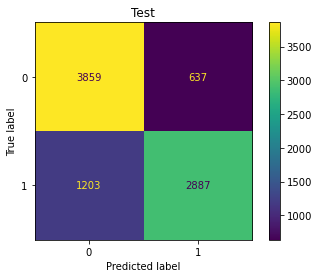

accuracy-score on test set :  0.7856976473328675
precision-score on test set :  0.8192395005675369
recall-score on test set :  0.7058679706601467
F1-score on test set :  0.7583399001838718


In [47]:
#Matrice et score pour test avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_svm, x_test_vec,y_test)
cm_vec.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", cv_svm.score(x_test_vec, y_test))
print("precision-score on test set : ", precision_score(y_test,cv_svm.predict(x_test_vec)))
print("recall-score on test set : ", recall_score(y_test,cv_svm.predict(x_test_vec)))
print("F1-score on test set : ", f1_score(y_test,cv_svm.predict(x_test_vec)))

In [48]:
# SVM avec TfidfVectorizer

tv_svm = SVC()
tv_svm.fit(x_train_tfidf,y_train)

SVC()

In [49]:
# score train
tv_svm.score(x_train_tfidf,y_train)

0.9908641605511457

In [50]:
# score test
tv_svm.score(x_test_tfidf,y_test)

0.7860470533426508

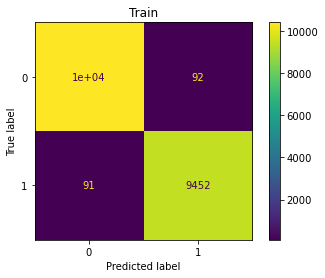

accuracy-score on train set :  0.9908641605511457
precision-score on train set :  0.990360435875943
recall-score on train set :  0.9904642146075657
F1-score on train set :  0.9904123225231833


In [51]:
#Matrice et score pour train avec TidfVecorizer
cm_tf = plot_confusion_matrix(tv_svm, x_train_tfidf,y_train)
cm_tf.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", tv_svm.score(x_train_tfidf, y_train))
print("precision-score on train set : ", precision_score(y_train,tv_svm.predict(x_train_tfidf)))
print("recall-score on train set : ", recall_score(y_train,tv_svm.predict(x_train_tfidf)))
print("F1-score on train set : ", f1_score(y_train,tv_svm.predict(x_train_tfidf)))

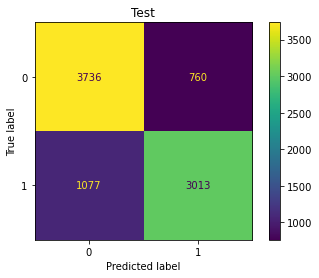

accuracy-score on test set :  0.7860470533426508
precision-score on test set :  0.7985687781606149
recall-score on test set :  0.7366748166259168
F1-score on test set :  0.7663741574462672


In [52]:
#Matrice et score pour test avec TidfVecorizer
cm_tf = plot_confusion_matrix(tv_svm, x_test_tfidf,y_test)
cm_tf.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", tv_svm.score(x_test_tfidf, y_test))
print("precision-score on test set : ", precision_score(y_test,tv_svm.predict(x_test_tfidf)))
print("recall-score on test set : ", recall_score(y_test,tv_svm.predict(x_test_tfidf)))
print("F1-score on test set : ", f1_score(y_test,tv_svm.predict(x_test_tfidf)))

**Gradient Boosting Classifier**

In [53]:
#xgb = GradientBoostingClassifier()
#xgb.fit(x_train_vec,y_train)
#xgb.score(x_train_vec,y_train)
#xgb.score(x_test_vec,y_test)

In [54]:
# Gradient Boosting avec CountVectorizer

cv_gb = GradientBoostingClassifier()
cv_gb.fit(x_train_vec,y_train)

GradientBoostingClassifier()

In [55]:
# score train
cv_gb.score(x_train_vec,y_train)

0.6835904348260197

In [56]:
# score test
cv_gb.score(x_test_vec,y_test)

0.6597950151409271

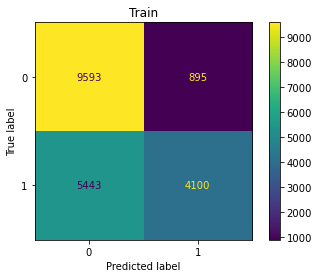

accuracy-score on train set :  0.6835904348260197
precision-score on train set :  0.8208208208208209
recall-score on train set :  0.42963428691187255
F1-score on train set :  0.5640390700233869


In [57]:
#Matrice et score pour train avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_gb, x_train_vec,y_train)
cm_vec.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", cv_gb.score(x_train_vec, y_train))
print("precision-score on train set : ", precision_score(y_train,cv_gb.predict(x_train_vec)))
print("recall-score on train set : ", recall_score(y_train,cv_gb.predict(x_train_vec)))
print("F1-score on train set : ", f1_score(y_train,cv_gb.predict(x_train_vec)))

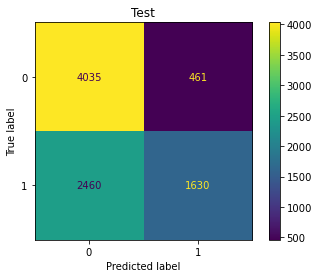

accuracy-score on test set :  0.6597950151409271
precision-score on test set :  0.779531324725012
recall-score on test set :  0.39853300733496333
F1-score on test set :  0.5274227471282964


In [58]:
#Matrice et score pour test avec CountVectorizer
cm_vec = plot_confusion_matrix(cv_gb, x_test_vec,y_test)
cm_vec.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", cv_gb.score(x_test_vec, y_test))
print("precision-score on test set : ", precision_score(y_test,cv_gb.predict(x_test_vec)))
print("recall-score on test set : ", recall_score(y_test,cv_gb.predict(x_test_vec)))
print("F1-score on test set : ", f1_score(y_test,cv_gb.predict(x_test_vec)))

In [59]:
# Gradient Boosting avec TfidfVectorizer

tv_gb = GradientBoostingClassifier()
tv_gb.fit(x_train_tfidf,y_train)

GradientBoostingClassifier()

In [60]:
# score train
tv_gb.score(x_train_tfidf,y_train)

0.689032000399381

In [61]:
# score test
tv_gb.score(x_test_tfidf,y_test)

0.6643372932681109

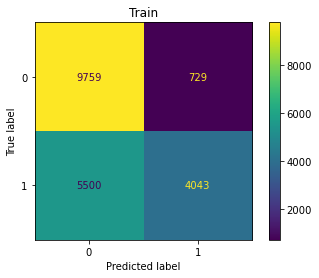

accuracy-score on train set :  0.689032000399381
precision-score on train set :  0.8472338642078793
recall-score on train set :  0.42366132243529286
F1-score on train set :  0.564862032832693


In [62]:
#Matrice et score pour train avec TidfVecorizer
cm_tf = plot_confusion_matrix(tv_gb, x_train_tfidf,y_train)
cm_tf.ax_.set_title("Train")
plt.show()
print("accuracy-score on train set : ", tv_gb.score(x_train_tfidf, y_train))
print("precision-score on train set : ", precision_score(y_train,tv_gb.predict(x_train_tfidf)))
print("recall-score on train set : ", recall_score(y_train,tv_gb.predict(x_train_tfidf)))
print("F1-score on train set : ", f1_score(y_train,tv_gb.predict(x_train_tfidf)))

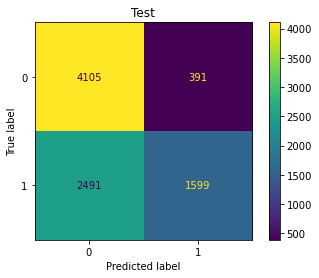

accuracy-score on test set :  0.6643372932681109
precision-score on test set :  0.8035175879396985
recall-score on test set :  0.3909535452322738
F1-score on test set :  0.5259868421052631


In [63]:
#Matrice et score pour test avec TidfVecorizer
cm_tf = plot_confusion_matrix(tv_gb, x_test_tfidf,y_test)
cm_tf.ax_.set_title("Test")
plt.show()
print("accuracy-score on test set : ", tv_gb.score(x_test_tfidf, y_test))
print("precision-score on test set : ", precision_score(y_test,tv_gb.predict(x_test_tfidf)))
print("recall-score on test set : ", recall_score(y_test,tv_gb.predict(x_test_tfidf)))
print("F1-score on test set : ", f1_score(y_test,tv_gb.predict(x_test_tfidf)))

In [64]:
#vanne_de_merde = pd.DataFrame(['seriously there are even people who xhere shoes worth 100k'], column='Momo')